In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Graduation Project/MIMIC/p11_subset1.zip" -d "datasets1/"

Reading in the file paths to all MIMIC-CXR images


  0%|          | 0/199 [00:00<?, ?it/s]

100%|██████████| 199/199 [00:00<00:00, 21489.87it/s]

pathes ['datasets/mimic-cxr-jpg/files/p11/p11001469/s54076811/d0d2bd0c-8bc50aa2-a9ab3ca1-cf9c9404-543a10b7.jpg', 'datasets/mimic-cxr-jpg/files/p11/p11002268/s51865072/a41f8198-de15ea4c-c296f762-721eef61-0288555e.jpg', 'datasets/mimic-cxr-jpg/files/p11/p11002268/s57561051/4a62e451-665fb8d2-9d037176-e88bb926-9b6beed0.jpg', 'datasets/mimic-cxr-jpg/files/p11/p11002268/s58299091/03cdebdd-aa193e73-640acbc2-56be5af3-48e1128b.jpg', 'datasets/mimic-cxr-jpg/files/p11/p11002268/s58301648/a57c42a3-a519a3eb-50a43237-c6d2eacb-fbae58b3.jpg', 'datasets/mimic-cxr-jpg/files/p11/p11002268/s59019041/174a3be8-3b3995cb-082433d9-b99dbd44-e4003ccb.jpg', 'datasets/mimic-cxr-jpg/files/p11/p11005736/s50605423/ac9e83cd-d84dd883-0a620277-76208a40-88cf2dc0.jpg', 'datasets/mimic-cxr-jpg/files/p11/p11005736/s52195959/f18e6c73-1fb3d2e5-5ed214ad-3ddd23e9-afd310a5.jpg', 'datasets/mimic-cxr-jpg/files/p11/p11005736/s53108230/7a8c4e1c-e20041ff-a14a8e6b-a0d1ef4e-eef635e8.jpg', 'datasets/mimic-cxr-jpg/files/p11/p11005736/s53


mean: 0.474
std: 0.301


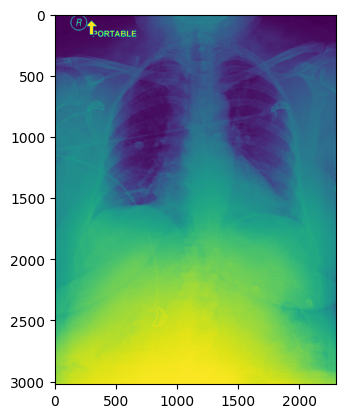

In [3]:
import os
import csv

import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt


def get_mean_std(image_paths) -> tuple([float, float]):
    mean = 0.0
    std = 0.0
    counter = 0

    for num_image, image_path in enumerate(image_paths, start=1):
        # image is a np array of shape (h, w) with pixel (integer) values between [0, 255]
        # note that there is no channel dimension, because images are grayscales and cv2.IMREAD_UNCHANGED is specified
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        # pixel values have to be normalized to between [0.0, 1.0], since we need mean and std values in the range [0.0, 1.0]
        # this is because the transforms.Normalize class applies normalization by the formula: img = (img - mean * max_pixel_value) / (std * max_pixel_value)
        # with max_pixel_value=255.0
        image = image / 255.

        mean += image.mean()
        std += image.std()

    return mean / num_image, std / num_image

def get_total_num_rows(path_csv_file: str) -> int:
    with open(path_csv_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        # skip the first line (i.e. the header line)
        next(csv_reader)
        return sum(1 for row in csv_reader)

def get_image_paths_mimic() -> list:
    """
    Returns a list of all file paths to mimic-cxr images.
    """
    print("Reading in the file paths to all MIMIC-CXR images")
    image_paths = []
    path_mimic_cxr_jpg = ""
    path_csv_file="datasets/train-200.csv"
    total_num_rows = get_total_num_rows(path_csv_file)
    with open(path_csv_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        # skip the first line (i.e. the header line)
        next(csv_reader)
        for row in tqdm(csv_reader, total=total_num_rows):
            mimic_image_file_path = os.path.join(path_mimic_cxr_jpg, row[3])
            image_paths.append(mimic_image_file_path)

    return image_paths
def normalize_image(image_path: str, mean: float, std: float) -> np.array:
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        # plt.imshow(image)
        image = image / 255.
        image = (image - mean) / std
        #plot image
        plt.imshow(image)
        return image

def main():
    image_paths = get_image_paths_mimic()
    print("pathes",image_paths)
    mean, std = get_mean_std(image_paths)
    print()
    print(f"mean: {mean:.3f}")
    print(f"std: {std:.3f}")
    normalize_image(image_paths[0], mean ,std)


if __name__ == "__main__":
    main()


In [ ]:
!pip install -U albumentations


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [ ]:
def get_transforms(dataset: str):
    # see compute_mean_std_dataset.py in src/dataset
    mean = 0.471
    std = 0.302

    # use albumentations for Compose and transforms
    # augmentations are applied with prob=0.5
    # since Affine translates and rotates the image, we also have to do the same with the bounding boxes, hence the bbox_params arugment
    train_transforms = A.Compose(
        [
            # we want the long edge of the image to be resized to IMAGE_INPUT_SIZE, and the short edge of the image to be padded to IMAGE_INPUT_SIZE on both sides,
            # such that the aspect ratio of the images are kept, while getting images of uniform size (IMAGE_INPUT_SIZE x IMAGE_INPUT_SIZE)
            # LongestMaxSize: resizes the longer edge to IMAGE_INPUT_SIZE while maintaining the aspect ratio
            # INTER_AREA works best for shrinking images
            A.LongestMaxSize(max_size=512, interpolation=cv2.INTER_AREA),
            A.ColorJitter(hue=0.0),
            A.GaussNoise(),
            # randomly (by default prob=0.5) translate and rotate image
            # mode and cval specify that black pixels are used to fill in newly created pixels
            # translate between -2% and 2% of the image height/width, rotate between -2 and 2 degrees
            A.Affine(mode=cv2.BORDER_CONSTANT, cval=0, translate_percent=(-0.02, 0.02), rotate=(-2, 2)),
            # PadIfNeeded: pads both sides of the shorter edge with 0's (black pixels)
            A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])